# Business in Elche

To see this jupyter notebook properly, copy the url of github in: https://nbviewer.jupyter.org/

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we are willing to open a **Padel Tennis Club** in a neighborhood with high **Annual Income** so paying the inscription is not a problem. This Padel Club is a new sport in Elche, so it may be a good oportunity investing.

In times of Covid-19, the people is concerned about the minimum distance across individuals. So an investor is willing to open a Padel Tennis Club where people can do sport in a secure way.

In order to achieve this objective, we're going to use Foursquare API to know where can be a good location and where are the other similar clubs, trying to be a step away from other clubs.

This club is for people who wants to stay healthy and to achieve this status, they want to do it in a funny and secure way.

## Data <a name="data"></a>

For this project, we are using the **Foursquare API** location to know in **neighborhoods** has a Padel Tennis Club and how common it is. Also, in order to make this project more reliable, there will be an approximation on the **annual income** of each neighborhood, because people with more income wants to be social distinguised, so this also attracts other people that want to enter in this world.

The factors that influence our decisions are:
* Number of existing Padel Clubs in any Postal Code
* Annual income for each Postal Code
* Distance between existing clubs

So we are selecting a club in a **high annual income** postal code, that is **far away** from any existing club.

Each **Neighborhoods** have a **Postal Code** and some neighborhoods have the same postal code, so it's a good distribution of different areas of Elche. As long as we only have the location of postal codes, we are using **Postal Codes** to predict the **optimal location** of a future Padel Tennis Club.

* The **Postal Code** database is made by hand, as well as the latitude and longitude of each postal code, using the google maps application. The **Postal Code** are copied from here [Postal Codes](http://distritopostal.es/alicante/elche-elx)
* The **Annual Income** is copied from this webpage, when you must enter the Postal Code and it outputs the income, there are some postal codes that hasn't annual income, so the income is the same as the nearest postal code. The webpage is this [Annual Income](https://www.lavanguardia.com/economia/20191015/471004818650/renta-codigo-postal-ricos-pobres-barrios-municipio.html)
* We use the **Foursquare API location** to know if there is any **Padel Club** or similar in Elche and where is located. Also we use the venues to cluster postal codes using **k-means** according to its venues.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

### Create DataFrame of *Postal Codes*, *Neighborhoods* and *Annual Income* in Elche with pandas

Create a DataFrame manually as this information is only available locally.

In [78]:
data = {"Postal Code" : ["03139", "03194", "03195", "03201", "03202", "03203", "03204", "03205","03206", "03207", "03208", "03291", "03292", "03294", "03295", "03296", "03320"],
       "Borough" : ["Camp d'Elx", "Camp d'Elx", "Camp d'Elx", "El Pla", "Altabix", "Altabix", "El Pla", "Carrús", "Carrús", "Camp d'Elx", "Altabix", "Camp d'Elx", "Camp d'Elx", "Camp d'Elx", "Camp d'Elx", "Camp d'Elx", "Torrellano"],
       "Neighborhood" : ["Valverde", "La Marina", "El Altet, Los Arenales", "Pont Nou, El Pla Alt", "Altabix, Candalix, Ciutat Esportiva", "Altabix Sur, Palmerales, La Torreta", "El Pla", "El Toscar", "Carrús Est", "La Galia", "Camp de Futbol", "Bonavista", "Las Bayas", "La Foia", "Maitino, Perleta", "Matola, Algoda", "Torrellano"],
       "Latitude" : [38.236437, 38.147014, 38.265322, 38.265580, 38.271360, 38.263938, 38.258853, 38.268918, 38.273851, 38.283386, 38.264313, 38.299481, 38.217869, 38.210718, 38.262412, 38.232012, 38.291186],
       "Longitude" : [-0.597824, -0.644511, -0.546587, -0.705921, -0.684831, -0.687454, -0.705489, -0.714424, -0.707434, -0.690748, -0.664464, -0.681519, -0.640361, -0.682850, -0.634930, -0.745682, -0.590044],
       "Annual Income" : [22213, 20000, 22213, 21638, 23595, 26155, 18618, 16811, 15320, 20000, 20000, 20000, 20264, 18711, 25067, 22576, 20474]}
df = pd.DataFrame (data, columns = ["Postal Code", "Borough", "Neighborhood", "Latitude", "Longitude", "Annual Income"])
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Annual Income
0,03139,Camp d'Elx,Valverde,38.236437,-0.597824,22213
1,03194,Camp d'Elx,La Marina,38.147014,-0.644511,20000
2,03195,Camp d'Elx,"El Altet, Los Arenales",38.265322,-0.546587,22213
3,03201,El Pla,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638
4,03202,Altabix,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595


### Shape of the dataframe

In [15]:
df.shape

(17, 6)

### How many unique borough have elche

In [31]:
neighborhoods = df
neighborhoods.drop(["Postal Code", "Annual Income"], axis=1)

,Borough,Neighborhood,Latitude,Longitude
0,Camp d'Elx,Valverde,38.236437,-0.597824
1,Camp d'Elx,La Marina,38.147014,-0.644511
2,Camp d'Elx,"El Altet, Los Arenales",38.265322,-0.546587
3,El Pla,"Pont Nou, El Pla Alt",38.265580,-0.705921
4,Altabix,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831
5,Altabix,"Altabix Sur, Palmerales, La Torreta",38.263938,-0.687454
6,El Pla,El Pla,38.258853,-0.705489
7,Carrús,El Toscar,38.268918,-0.714424
8,Carrús,Carrús Est,38.273851,-0.707434
9,Camp d'Elx,La Galia,38.283386,-0.690748


In [24]:
print('The dataframe has {} boroughs and {} Postal Codes.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 17 Postal Codes.


#### Use geopy library to get the latitude and longitude values of Elche.

In [22]:
address = 'Elche, Spain'

geolocator = Nominatim(user_agent="spain_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Elche City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Elche City are 38.2653181, -0.6988488.


#### Create a map of Elche with **Postal Codes** superimposed on top.

In [149]:
# create map of Elche using latitude and longitude values
map_elche = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color = 'blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_elche)  
    
map_elche

Next, we are going to start utilizing the Foursquare API to explore the Postal Codes

### Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = '3BYUZL4WX20DWNURR5PQQRY5MIHE3PZNE3E0REKDJUZ11L3Z' # your Foursquare ID
CLIENT_SECRET = 'GXQL5JCV1SQW2SHOVHUUIHEEZJ3LJJ2E3PGNLBVDOZIQIFKG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3BYUZL4WX20DWNURR5PQQRY5MIHE3PZNE3E0REKDJUZ11L3Z
CLIENT_SECRET:GXQL5JCV1SQW2SHOVHUUIHEEZJ3LJJ2E3PGNLBVDOZIQIFKG


From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Let's create a function to repeat the same process to all the neighborhoods in Elche

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print(url)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now run the above function on each neighborhood and create a new dataframe called *elche_venues*.

In [34]:
elche_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Valverde
La Marina
El Altet, Los Arenales
Pont Nou, El Pla Alt
Altabix, Candalix, Ciutat Esportiva
Altabix Sur, Palmerales, La Torreta
El Pla
El Toscar
Carrús Est
La Galia
Camp de Futbol
Bonavista
Las Bayas
La Foia
Maitino, Perleta
Matola, Algoda
Torrellano


#### Let's find out how many unique categories can be curated from all the returned venues

In [38]:
print('There are {} uniques categories.'.format(len(elche_venues['Venue Category'].unique())))

There are 42 uniques categories.


### Analyze Each Neighborhood

In [39]:
# one hot encoding
elche_onehot = pd.get_dummies(elche_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
elche_onehot['Neighborhood'] = elche_venues['Neighborhood'] 

# move neighborhood column to the first column
mid = elche_onehot['Neighborhood']
elche_onehot.drop(labels=['Neighborhood'], axis=1, inplace = True)
elche_onehot.insert(0, 'Neighborhood', mid)

elche_onehot.head()

,Neighborhood,Athletics & Sports,BBQ Joint,Bakery,Bar,Botanical Garden,Breakfast Spot,Bus Stop,Café,Chocolate Shop,...,Pub,Recreation Center,Restaurant,Snack Place,Soccer Stadium,Spanish Restaurant,Stadium,Tapas Restaurant,Tennis Court,Vegetarian / Vegan Restaurant
0,Valverde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Valverde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Valverde,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Valverde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,La Marina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [62]:
elche_grouped = elche_onehot.groupby('Neighborhood').mean().reset_index()
elche_grouped

,Neighborhood,Athletics & Sports,BBQ Joint,Bakery,Bar,Botanical Garden,Breakfast Spot,Bus Stop,Café,Chocolate Shop,...,Pub,Recreation Center,Restaurant,Snack Place,Soccer Stadium,Spanish Restaurant,Stadium,Tapas Restaurant,Tennis Court,Vegetarian / Vegan Restaurant
0,"Altabix Sur, Palmerales, La Torreta",0.000000,0.000000,0.000000,0.000000,0.2,0.000,0.00,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000
1,"Altabix, Candalix, Ciutat Esportiva",0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.071429,0.071429,0.000000,0.071429
2,Bonavista,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Camp de Futbol,0.000000,0.000000,0.000000,0.166667,0.0,0.000,0.00,0.000000,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.166667,0.333333,0.000000,0.000000,0.166667,0.000000
4,Carrús Est,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.25,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"El Altet, Los Arenales",0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,El Pla,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.090909,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.181818,0.000000,0.000000
7,El Toscar,0.000000,0.000000,0.000000,0.000000,0.0,0.125,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,La Foia,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
9,La Galia,0.000000,0.000000,0.000000,0.000000,0.0,0.500,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's write a function to sort the venues in descending order.

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = elche_grouped['Neighborhood']

for ind in np.arange(elche_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(elche_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Altabix Sur, Palmerales, La Torreta",Vegetarian / Vegan Restaurant,Spanish Restaurant,Hotel,Botanical Garden,Café,Construction & Landscaping,Farmers Market,Falafel Restaurant,Diner,Dessert Shop
1,"Altabix, Candalix, Ciutat Esportiva",Grocery Store,Café,Spanish Restaurant,Plaza,Falafel Restaurant,Italian Restaurant,Park,Pizza Place,Vegetarian / Vegan Restaurant,Stadium
2,Bonavista,Gym / Fitness Center,Construction & Landscaping,Coffee Shop,Flower Shop,Farmers Market,Falafel Restaurant,Diner,Dessert Shop,Cupcake Shop,Convenience Store
3,Camp de Futbol,Spanish Restaurant,Tennis Court,Soccer Stadium,Bar,Recreation Center,Vegetarian / Vegan Restaurant,Coffee Shop,Falafel Restaurant,Diner,Dessert Shop
4,Carrús Est,Gym / Fitness Center,Diner,Bus Stop,Plaza,Vegetarian / Vegan Restaurant,Coffee Shop,Farmers Market,Falafel Restaurant,Dessert Shop,Cupcake Shop


Now we conclude the **Data Section**

## Methodology <a name="methodology"></a>

Now we are clustering neighborhoods with k-means to select the optimal location, so we are going to locate in the same cluster because if it works in one neighborhood there are more probabilities that can work in a similar neighborhood than in other cluster with other forms of living.
The prerrequisites for an optimal location are:
* The location must be in the same cluster but in a different neighborhood
* The neighborhood has the highest possible annual income
* It’s located the further away from existing clubs as possible


## Analysis <a name="analysis"></a>

First let's **cluster** the neighborhoods, because we want the location to be in a similar cluster. Then we can explore the **annual income** graph and the location of existing **padel tennis clubs**.

### Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [65]:
# set number of clusters
kclusters = 5

elche_grouped_clustering = elche_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(elche_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 1, 0, 0, 0, 3])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [66]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

elche_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
elche_merged = elche_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

elche_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Annual Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,03139,Camp d'Elx,Valverde,38.236437,-0.597824,22213,0,Cocktail Bar,Spanish Restaurant,Bar,Paella Restaurant,Coffee Shop,Farmers Market,Falafel Restaurant,Diner,Dessert Shop,Cupcake Shop
1,03194,Camp d'Elx,La Marina,38.147014,-0.644511,20000,0,Spanish Restaurant,Pizza Place,Café,Cocktail Bar,Farmers Market,Falafel Restaurant,Diner,Dessert Shop,Cupcake Shop,Convenience Store
2,03195,Camp d'Elx,"El Altet, Los Arenales",38.265322,-0.546587,22213,1,Flower Shop,Vegetarian / Vegan Restaurant,Coffee Shop,Farmers Market,Falafel Restaurant,Diner,Dessert Shop,Cupcake Shop,Convenience Store,Construction & Landscaping
3,03201,El Pla,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638,0,Café,Spanish Restaurant,Ice Cream Shop,Park,Vegetarian / Vegan Restaurant,Pizza Place,Cupcake Shop,Chocolate Shop,Mediterranean Restaurant,Diner
4,03202,Altabix,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595,0,Grocery Store,Café,Spanish Restaurant,Plaza,Falafel Restaurant,Italian Restaurant,Park,Pizza Place,Vegetarian / Vegan Restaurant,Stadium


Finally, let's visualize the resulting clusters

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
#elche_merged['Cluster Labels'].fillna(0,inplace=True)
for lat, lon, poi, cluster in zip(elche_merged['Latitude'], elche_merged['Longitude'], elche_merged['Neighborhood'], elche_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see the neighborhoods that are near the center of the city are in the **same cluster** and the others that are far from the center, are in **different clusters**, this correlates what my experience know, because near the center there is a big city that has lots of venues, and far from the center the most common venues are *Bar* and *Restaurants*.

#### Now let's plot the Annual Income across Neighborhoods

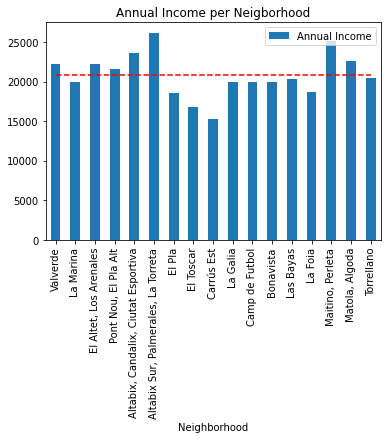

In [37]:
df.plot(x="Neighborhood", y="Annual Income", kind="bar", title="Annual Income per Neigborhood")
plt.hlines(df["Annual Income"].mean(), xmin=0, xmax=16, linestyles='dashed', color = "red")
plt.show()

So the higher annual income are : **Altabix Sur** (Cluster 0), **Maitino** (Cluster 4) and **Altabix** (Cluster 0)

#### Let's find out how many unique *Tennis Court* are in Elche

In [68]:
print("There are {} Padel Tennis Court in Elche.".format(len(elche_venues[elche_venues["Venue Category"] == "Tennis Court"])))

There are 1 Padel Tennis Court in Elche.


#### In which neighborhood is the Tennis Court?

In [69]:
elche_venues[elche_venues["Venue Category"] == "Tennis Court"].Neighborhood

76    Camp de Futbol
Name: Neighborhood, dtype: object

The existing **Padel Tennis Club** is in **Camp de futbol** neighborhood, that is in **Cluster 0**, so let's print this cluster with **Anual Income** in descending order.

First we need to modify the dataframe and add the cluster labels.

In [79]:
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Postal Code,Borough,Neighborhood,Latitude,Longitude,Annual Income
0,0,03139,Camp d'Elx,Valverde,38.236437,-0.597824,22213
1,0,03194,Camp d'Elx,La Marina,38.147014,-0.644511,20000
2,2,03195,Camp d'Elx,"El Altet, Los Arenales",38.265322,-0.546587,22213
3,0,03201,El Pla,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638
4,0,03202,Altabix,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595


Now we are selecting the Neighborhoods in **Cluster 0** and sorting it in **descending Annual Income** order.

In [114]:
cluster0 = elche_merged.loc[elche_merged['Cluster Labels'] == 0].sort_values(by=['Annual Income'], ascending = False)
cluster0_selection = cluster0[["Neighborhood", "Latitude", "Longitude", "Annual Income"]].head()
cluster0_selection.head()

,Neighborhood,Latitude,Longitude,Annual Income
5,"Altabix Sur, Palmerales, La Torreta",38.263938,-0.687454,26155
4,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595
0,Valverde,38.236437,-0.597824,22213
3,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638
16,Torrellano,38.291186,-0.590044,20474


Now let's calculate the **distance** to the existing court neighborhood.

In [115]:
from math import sin, cos, sqrt, atan2, radians

def distance_lat_long(x,y):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(df.loc[df['Neighborhood'] == "Camp de Futbol"]["Latitude"])
    lon1 = radians(df.loc[df['Neighborhood'] == "Camp de Futbol"]["Longitude"])
    lat2 = radians(x)
    lon2 = radians(y)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

Let's calculate the **distance** for each neighborhood from the existing Padel Tennis Club.

In [116]:
cluster0_selection.reset_index(inplace=True)
cluster0_selection["Distance (Km)"] = 0 # let's create the column distance

for i in range(len(cluster0_selection)): # loop through neighborhoods
    cluster0_selection.loc[i, "Distance (Km)"] = distance_lat_long(cluster0_selection.loc[i,"Latitude"], cluster0_selection.loc[0,"Longitude"]) 

cluster0_selection.head()

,index,Neighborhood,Latitude,Longitude,Annual Income,Distance (Km)
0,5,"Altabix Sur, Palmerales, La Torreta",38.263938,-0.687454,26155,2.008235
1,4,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595,2.155285
2,0,Valverde,38.236437,-0.597824,22213,3.694155
3,3,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638,2.012719
4,16,Torrellano,38.291186,-0.590044,20474,3.600604


Now let's select the **optimal location** that has the **higher annual income** and it's **further away**.

In [123]:
cluster0_selection.sort_values(['Annual Income', 'Distance (Km)'], ascending=[False, False])

,index,Neighborhood,Latitude,Longitude,Annual Income,Distance (Km)
0,5,"Altabix Sur, Palmerales, La Torreta",38.263938,-0.687454,26155,2.008235
1,4,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595,2.155285
2,0,Valverde,38.236437,-0.597824,22213,3.694155
3,3,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638,2.012719
4,16,Torrellano,38.291186,-0.590044,20474,3.600604


As we can see the highest annual income not is the furthest away, so we're **ranking the values of both columns**, being the hihest annual income 5 points and the lowest income with 1 point. The same for the distance, the furthest distance with 5 points and the lowest with 1 point. Then we're suming both columns, and our **optimum location** is the highest value.

In [140]:
cluster0_selection["rank Income"] = cluster0_selection["Annual Income"].rank(ascending=True)
cluster0_selection["rank Distance"] = cluster0_selection["Distance (Km)"].rank(ascending=True)
cluster0_selection["total rank"] = cluster0_selection["rank Income"] + cluster0_selection["rank Distance"]
cluster0_selection.head()

,index,Neighborhood,Latitude,Longitude,Annual Income,Distance (Km),rank Income,rank Distance,total rank
0,5,"Altabix Sur, Palmerales, La Torreta",38.263938,-0.687454,26155,2.008235,5.0,1.0,6.0
1,4,"Altabix, Candalix, Ciutat Esportiva",38.271360,-0.684831,23595,2.155285,4.0,3.0,7.0
2,0,Valverde,38.236437,-0.597824,22213,3.694155,3.0,5.0,8.0
3,3,"Pont Nou, El Pla Alt",38.265580,-0.705921,21638,2.012719,2.0,2.0,4.0
4,16,Torrellano,38.291186,-0.590044,20474,3.600604,1.0,4.0,5.0


So the **optimal location** is in **Valverde** with 8 points.

## Results and Discussion <a name="results"></a>

Our analysis shows that there is only one padel tennis club in Elche, meaning that there is a good bussiness oportunity, this club is in the major cluster, near the center of the city. We have decided to open a new club in a different neighborhood to avoid competition, also we have calculated the distance from this existing club in order to be as far away as possible, also is pondering in the final decision, the annual income of the neighborhood, being the highest the better. All in all, we are pondering the annual income and the distance from the existing club with the same weight, maybe other approximation can be better, or including other parameters as population density. 

## Conclusion <a name="conclusion"></a>

The purpose of this project was to find a optimal location to open a padel tennis club, that was far from the existing ones and the neighborhood has a high annual income. We have used both parameters equally, resulting in an **optimal location** far from the center of the city, but in a peaceful neighborhood, automating all the download data can be taken into account in a future time, as well as, evaluating other parameters as population density, available surface area and others. All in all, this is a research project that is not intended to make any business decision, but can be a good starting point for other projects.